# Importing Libraries

In [ ]:
from utils import *
from sklearn.manifold import TSNE
from datetime import datetime
from time import time

In [ ]:
MAX_LENGTH = 50

## Reading the Data In
We are using the Air Travel Information System (ATIS) dataset(I believe it is originally from UPenn, need to verify)
It uses the Inside-Out-Beginning tag format(IOB) described here : https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)

The typical structure is:

Sentence (tokens), Slots to match each token, Intent.

Found a preprocessed atis file from, thanks to: https://github.com/D2KLab/botcycle/tree/master/nlu/data/atis


In [3]:
with open('data/preprocessed/fold_train.json', 'r') as f:
    atis_json = json.load(f)

In [4]:
#atis_json['data'][0]

# Data Preprocessing

In [5]:
def flatten(list_of_lists):
    """Flattens from two-dimensional list to one-dimensional list"""
    return [item for sublist in list_of_lists for item in sublist]

In [6]:
def adjust_sequences(data, length=MAX_LENGTH):
    """
    Fixes the input and output sequences length, adding padding or truncating if necessary
    :param data json file containing entries from atis dataset.
    :param length the fixed length of the sentence.
    """
    for sample in data['data']:
        # adjust the sequence of input words
        if len(sample['words']) < length:
            # add <EOS> and <PAD> if sentence is shorter than maximum length
            sample['words'].append('<EOS>')
            while len(sample['words']) < length:
                sample['words'].append('<PAD>')
        else:
            # otherwise truncate and add <EOS> at last position
            sample['words'] = sample['words'][:length]
            sample['words'][-1] = '<EOS>'

        # adjust in the same way the sequence of output slots
        if len(sample['slots']) < length:
            sample['slots'].append('<EOS>')
            while len(sample['slots']) < length:
                sample['slots'].append('<PAD>')
        else:
            sample['slots'] = sample['slots'][:length]
            sample['slots'][-1] = '<EOS>'

    return data

In [7]:
def get_vocabularies(train_data):
    """
    Collect the input vocabulary, the slot vocabulary and the intent vocabulary
    :param train_data the training data containing words,slots and intent.
    """
    # from a list of training examples, get three lists (columns)
    data = train_data['data']
    seq_in = [sample['words'] for sample in data]
    vocab = flatten(seq_in)
    # removing duplicated but keeping the order
    v = ['<PAD>', '<SOS>', '<EOS>'] + vocab
    vocab = sorted(set(v), key=lambda x: v.index(x)) # https://docs.python.org/3.3/howto/sorting.html
    s = ['<PAD>','<EOS>'] + train_data['meta']['slot_types']
    slot_tag = sorted(set(s), key=lambda x: s.index(x))
    i = train_data['meta']['intent_types']
    intent_tag = sorted(set(i), key=lambda x: i.index(x))

    return vocab, slot_tag, intent_tag

In [8]:
adjusted_atis = adjust_sequences(atis_json)#padded

In [9]:
atis_vocab,atis_slots,atis_intents = get_vocabularies(adjusted_atis)

In [10]:
len(atis_vocab),len(atis_slots),len(atis_intents)

(870, 122, 21)

In [11]:
adjusted_atis['data'][0]['intent']

'atis_flight'

# Next we need to embed the data and set it up for Pytorch
Remember each vocabulary for each sentence, slot and intent will have different embeddings. They are different sized vectors. The Network will try to figure out a mapping from these different vector spaces.

In [12]:
def create_mappings(vocab,forward_map):
    """
    This function takes the words in the vocabulary and creates a unique mapping to a number.
    :param vocab contains all the words in the corpus.
    :param forward_map a dictionary that will be populated with mappings.
    returns populated forward_map
    """
    for sample in vocab:
        if sample not in forward_map.keys():
            forward_map[sample]= len(forward_map)
            
    return forward_map

In [13]:
SOS_token = 2
EOS_token = 3
word2index = {'<PAD>': 0, '<UNK>':1,'<SOS>':2,'<EOS>':3}
create_mappings(atis_vocab,word2index)
index2word = {v:k for k,v in word2index.items()}

In [14]:
tag2index = {'<PAD>' : 0,'<UNK>':1,'<EOS>':2}
create_mappings(atis_slots,tag2index)
index2tag = {v:k for k,v in tag2index.items()}

In [15]:
intent2index={}
create_mappings(atis_intents,intent2index)
index2intent = {v:k for k,v in intent2index.items()}

In [16]:
#intent2index
#len(word2index)
#len(tag2index)
#index2tag
#index2intent
#index2intent

### Next we create a Tensor where each row is a mapped/embedded sequence

In [17]:
def prepare_sequence(seq_data, mapping,map_type):
    """
    :param seq a sequnce which will be embedded as a vector
    :param mapping, a dictionary which contains how each element in the seq will be mapped to a number.
    :param map_type 'words','slots' or 'intent'
    returns a Pytorch Tensor.
    """
    if map_type=='intent':
        intent = seq_data[map_type]
        embeddings = mapping[intent] if intent in mapping.keys() else -1 #mapping["<UNK>"]
        return torch.tensor(embeddings)   
    else:
        embed_fnc = lambda word: mapping[word] if word in mapping.keys() else mapping["<UNK>"]
        embeddings = list(map(embed_fnc, seq_data[map_type])) 
        return torch.LongTensor(embeddings)

In [18]:
def create_training_set(padded_atis):
    """
    :param padded_atis, this is padded sequence data.
           Of the form seq,slots,intent. This function coverts 
           these into tensors.
    return train_data; [(seq_tensor,slot_tensor,intent_tensor)]
    """
    train_data = []
    atis_data = padded_atis['data']
    for i in range(len(atis_data)):
        seq_tensor = prepare_sequence(atis_data[i],word2index,'words')
        slot_tensor = prepare_sequence(atis_data[i],tag2index,'slots')
        intent_tensor = prepare_sequence(atis_data[i],intent2index,'intent')
        train_data.append((seq_tensor,slot_tensor,intent_tensor))
    return train_data

In [19]:
train_data = create_training_set(adjusted_atis)

In [20]:
#train_data[0]

### Distribution of Slots 

In [21]:
slot_data = []
for i in train_data:
    slot_data.append(i[0].numpy())
#sns.barplot(x=train_data[])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


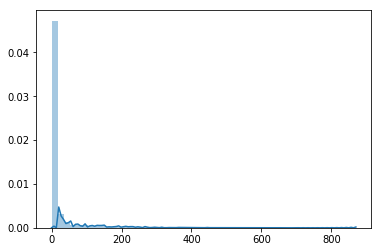

In [22]:
all_slot_data = np.concatenate(slot_data)
sns.distplot(all_slot_data)

### Batching the data

In [23]:
def concatenate_batch(batch):
#     print(len(batch), len(batch[0]))
    #     print([ex[0] for ex in batch])
    seqs = torch.stack([ex[0] for ex in batch])
    slots = torch.stack([ex[1] for ex in batch])
    intents = torch.stack([ex[2] for ex in batch])
   
    return seqs,slots,intents

In [24]:
def get_batches(batch_size, train_data):
    """
    Returns iteratively a batch of specified size on the data. 
    The last batch can be smaller if the total size is not multiple of the batch
    """
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while sindex < len(train_data):
        batch = train_data[sindex:eindex] #list of batch_size num of tuples.
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        #print('returning', len(batch), 'samples')
        yield concatenate_batch(batch)

In [25]:
# batches = get_batches(5,train_data[:10])
# list(batches)[0][0].size()

# Building Joint -RNNless Model

In [26]:
class Encoder(nn.Module):
    """
    An encoder/decoder that
    takes a batch of sequences embeds the sequence and
    then runs it through a fully connected layer to predict slots and intent.
    """
    def __init__(self,input_dim,slot_dim,intent_dim,emb_dim):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.slot_dim = slot_dim
        self.intent_dim = intent_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.slot_fc = nn.Linear(emb_dim,slot_dim)
        self.intent_fc = nn.Linear(emb_dim,intent_dim)
        
    def forward(self,src):
        embedded = self.embedding(src)# get embedding for a word
        #print(embedded.size())
        slots = self.slot_fc(embedded)# then predict a slot using fc
        
        # Need average embedding for a sequence
        avg_embedding = embedded.mean(dim=1) #[50,5]-> [5] because don't have 50 different elements anymore just one.
        #print('embed',embedded.size())
        #print('avg embed:',avg_embedding.size())
        intent = self.intent_fc(avg_embedding)
        #print('intent pred',intent.size())
        # then put average embedding into intent fc
        
        return slots,intent,embedded

In [27]:
print("Testing models...")
n_layers = 1
INPUT_DIM = len(word2index)
SLOT_DIM = len(tag2index)
print('Inp: ',INPUT_DIM,'Slotdim: ',SLOT_DIM)
INTENT_DIM = len(index2intent)
embed_size = 5
inp = get_batches(1,train_data[:1])
encoder = Encoder(INPUT_DIM,SLOT_DIM,INTENT_DIM,embed_size)
# testing avg embedding
for data in inp:
    input,label,real_intent = data[0],data[1],data[2]#.type(torch.FloatTensor)
    slot,intent,_ = encoder(input)
    slot = torch.argmax(slot,dim=2)
    test_criterion = nn.CrossEntropyLoss()
#     print(real_intent.size(),intent.size())
#     print('real intent',real_intent,'predicted intent',intent)
    test_criterion(intent,real_intent)
    #intent = torch.argmax(intent,dim=1).type(torch.FloatTensor)
    #print(slot.size())
    #print(intent.size())
#batches = get_batches(5,train_data[:10]) # to get each representation of a word.

Testing models...
Inp:  871 Slotdim:  123


In [28]:
test_criterion = nn.CrossEntropyLoss()
real_intent,intent
test_criterion(intent,real_intent)

tensor(3.5670)

# Attempting to Train the encoder

In [57]:
encoder = Encoder(INPUT_DIM,SLOT_DIM,INTENT_DIM,embed_size)
criterion = nn.CrossEntropyLoss(ignore_index=0)#ignore <pad>
optimizer = optim.Adam(encoder.parameters(), lr=0.01)

In [58]:
len(atis_intents)

21

In [86]:
batch_size = 128
max_length = 50
INPUT_DIM = len(word2index)#
SLOT_DIM = len(tag2index)
INTENT_DIM = len(index2intent)
embed_size = 5
num_epochs = 200

for epoch in range(num_epochs):
    inp = get_batches(batch_size,train_data)
    encoder.train()
    for data in inp:
        # get the inputs
        inputs, labels, intents = data[0],data[1],data[2]
        inputs = inputs.type(torch.LongTensor)
        labels = labels.type(torch.LongTensor).view(-1) #squashing
        intents = intents#.type(torch.FloatTensor)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        out_slots, out_intents,_ = encoder(inputs)
        out_slots = out_slots.view(-1,123)
        
        slot_loss = criterion(out_slots, labels)
        intent_loss = criterion(out_intents, intents) 
        
        slot_loss.backward(retain_graph=True)
        intent_loss.backward()
        optimizer.step()
    if epoch%10==0:
        print('Slot Loss after epoch '+str(epoch)+':',slot_loss.item())
        print('Intent Loss after epoch '+str(epoch)+':',intent_loss.item())
        print('-----------------------------------------------')

Slot Loss after epoch 0: 0.24015697836875916
Intent Loss after epoch 0: 0.10661938041448593
-----------------------------------------------
Slot Loss after epoch 10: 0.241562619805336
Intent Loss after epoch 10: 0.10663196444511414
-----------------------------------------------
Slot Loss after epoch 20: 0.25634732842445374
Intent Loss after epoch 20: 0.03172006830573082
-----------------------------------------------
Slot Loss after epoch 30: 0.26464882493019104
Intent Loss after epoch 30: 0.02990551106631756
-----------------------------------------------
Slot Loss after epoch 40: 0.2676238417625427
Intent Loss after epoch 40: 0.035965390503406525
-----------------------------------------------
Slot Loss after epoch 50: 0.27262577414512634
Intent Loss after epoch 50: 0.018837006762623787
-----------------------------------------------
Slot Loss after epoch 60: 0.2667813301086426
Intent Loss after epoch 60: 0.02631627582013607
-----------------------------------------------
Slot Loss 

## Evaluation of Encoder

 
### TODO: Average F1 metric across all the classes.
 

In [62]:
with open('data/preprocessed/fold_test.json', 'r') as f:
    atis_test_json = json.load(f)

In [63]:
#atis_test_json['data'][0]

In [64]:
adjusted_atis_test = adjust_sequences(atis_test_json)#padded

In [65]:
test_vocab,test_slots,test_intents = get_vocabularies(adjusted_atis_test)
#test_intents,index2intent

In [66]:
test_data = create_training_set(adjusted_atis_test) # should we cr

In [67]:
len(test_data)#[0][1]

500

In [68]:
#Exclude pad 
def calc_bat_fscores(y_pred,y_true,predict_type='slot'):
    """
    Calc average f score for a batch.
    compares each predicted output in a batch to actual output.
    Then averages that.
    """
    batch_avg_f = []
    keep_slots = [i for i in tag2index.values() if i > 2]
    if predict_type=='slot':
        for pred_i in range(len(y_pred)):# range batch size
            #print(y_pred[pred_i].size())
            f_score = f1_score(y_true[pred_i], y_pred[pred_i],labels=keep_slots, average ='micro')  
            batch_avg_f.append(f_score)
    else:
        return f1_score(y_true,y_pred,average ='micro')
    return np.mean(batch_avg_f)

In [69]:
import warnings
warnings.filterwarnings('ignore')# get a lot of warnings because some labels are not predicted...

In [89]:
inp = get_batches(100,test_data)
encoder.eval()
f_slot_scores = []
f_intent_scores = []
for data in inp:
    # get the inputs
    inputs, labels , true_intents = data[0],data[1],data[2]
    inputs = inputs.type(torch.LongTensor)
    
    if USE_CUDA and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    
    slots ,intents, slot_embedding = encoder(inputs)
    y_pred_slots = torch.argmax(slots,dim=2)
    f_slot_scores.append(calc_bat_fscores(y_pred_slots,labels))
    y_pred_intents = torch.argmax(intents,dim=1)
    #print(y_pred_intents)
    #print(true_intents)
    #print(list(zip(true_intents.tolist(), y_pred_intents.tolist())))
    f_intent_scores.append(calc_bat_fscores(y_pred_intents,true_intents,predict_type='intent'))
print('Mean Slot F Metric :',np.mean(f_slot_scores))
print('-----------------------------------------------')
print('Mean Intent F Metric :',np.mean(f_intent_scores))

Mean Slot F Metric : 0.3207814003558727
-----------------------------------------------
Mean Intent F Metric : 0.9039999999999999


In [41]:
#  # Change line width
# plt.xlabel('Slot F1-Scores')
# sns.boxplot(y = f_slot_scores, linewidth=1,width=0.05)

# Confusion Matrix For Intents since there are much less 

In [71]:
def categoryFromOutput(output):
    category_i = output.item()
    return index2intent[category_i], category_i

In [43]:
for data in get_batches(1,test_data[0:1]):
    input,_,intent = data[0],data[1],data[2]
    #print(input.size())
    output,intent_pred,_  = encoder(input)
    predictions = torch.argmax(intent_pred,dim=1)[0]
    print(output.size())
    print(predictions)
    print(categoryFromOutput(predictions))


torch.Size([1, 50, 123])
tensor(16)
('atis_ground_service', 16)


In [72]:
all_categories = []
for category in intent2index.values():
    all_categories.append(category)
len(all_categories)

21

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

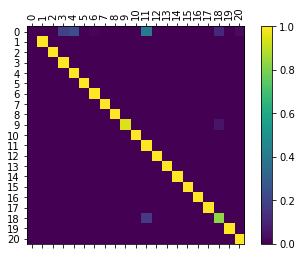

In [91]:
# Keep track of correct guesses in a confusion matrix
n_categories = len(all_categories)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 5000

# Go through a bunch of examples and record which are correctly guessed
for data in get_batches(1,test_data):
    inputs, labels , true_intents = data[0],data[1],data[2]
    output,intent_pred,_  = encoder(inputs)
    predictions = torch.argmax(intent_pred,dim=1)[0]
    #print(predictions, true_intents)
    guess, guess_i = categoryFromOutput(predictions)
    if true_intents.item()!= -1:#intent is in dataset
        category_i = all_categories.index(true_intents)
        confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories) #true

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# T-SNE
* Starting with 100 samples from the test set
* Then keeping track of the labels we pass the samples through our model to get an embedding: [batch size,50,5]
* With this embedding we try to drop remove the embeddings of 0 since they will appear often. 
* With the 0s removed, we apply T-SNE. 
* Plot the T-SNE embedding.

# Would a t-SNE visualization be useful?
Filter out top ten popular classes in testing set.
Then randomly sample slot emebddings from those.
Do the t-SNE embedding.
Remember embeddings are in order, this helps to label.

Looking t-SNE to visualize the results? How do the intent predictions and querie predictions look.
Are the intents near the queries when visualized?

Put in embedding into t-SNE and hopefully observe spatial semantic labels

output should be 870,2

color according to slot value and hopefully see color clusters
## Next TODO:
Get distribution of slots as well

Move to RNN next

Look up more info about MIT dataset


In [75]:
inp = get_batches(10,test_data)
encoder.eval()
for data in inp:
    inputs, labels , true_intents = data[0],data[1],data[2]
    inputs = inputs.type(torch.LongTensor)
    slots ,intents, slot_embedding = encoder(inputs)
slot_embedding.size()# the way it is now this is embedding of inp[90:100]

torch.Size([10, 50, 5])

In [76]:
pad_as_vector = slot_embedding[0][-1].detach().numpy()# will always be a pad
pad_as_vector#.shape

array([0.9095753 , 0.03358706, 0.26936164, 0.2606036 , 1.9761473 ],
      dtype=float32)

In [77]:
#slot_embedding#.size()
reshaped_slot_embed = slot_embedding.reshape(-1,5).detach().numpy()
#reshaped_slot_embed[0]

In [78]:
#https://stackoverflow.com/questions/26154711/filter-rows-of-a-numpy-array/26154854
def remove_zero_embed(row,zero_embed):
    return row != zero_embed
bool_arr = np.array([remove_zero_embed(row,pad_as_vector) for row in reshaped_slot_embed])

In [79]:
reshaped_slot_wo_zero = reshaped_slot_embed[bool_arr].reshape(-1,5)

In [80]:
reshaped_slot_wo_zero.shape

(139, 5)

In [81]:
#https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2,init='pca',random_state=423)

Computing t-SNE embedding


In [82]:
X_tsne = tsne.fit_transform(reshaped_slot_wo_zero)

In [83]:
#labels
reshaped_labels = labels.reshape(-1).detach().numpy()
reshaped_labels_wo_zero = reshaped_labels[reshaped_labels>0]
reshaped_labels_wo_zero.shape

(139,)

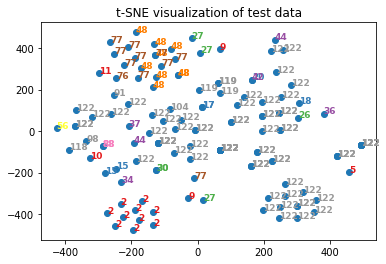

In [84]:
#print(X_tsne[:,0])
for i in range(X_tsne.shape[0]):
#     dist = np.sum((X_tsne[i] - shown_images) ** 2, 1)
#             if np.min(dist) < 4e-3:
#                 # don't show points that are too close
#                 continue
    plt.text(X_tsne[i, 0], X_tsne[i, 1], str(reshaped_labels_wo_zero[i]),
             color=plt.cm.Set1(reshaped_labels_wo_zero[i] / 100.),
             fontdict={'weight': 'bold', 'size': 9})
plt.scatter(X_tsne[:,0],X_tsne[:,1])
plt.title('t-SNE visualization of test data')
plt.show()